In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
df_students = pd.DataFrame({
    'student_id': [1, 2, 3, 4, 5, 6, 7, 8],
    'age': [20, 21, 19, 22, 20, 23, 21, 20],
    'gender': ['Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female'],
    'major': [
        'Computer Science',
        'Mechanical Engineering',
        'Environmental Science',
        'Civil Engineering',
        'Electrical Engineering',
        'Data Science',
        'Information Technology',
        'Chemical Engineering'
    ],
    'year': [3, 2, 1, 4, 2, 3, 1, 4],
    'interests': [
        'AI, Blockchain',
        'Robotics, Environmental Science',
        'Sustainability, Data Science',
        'AI, Fintech',
        'Blockchain, Robotics',
        'Machine Learning, Cloud Computing',
        'Cybersecurity, Big Data',
        'Renewable Energy, Nanotechnology'
    ]
})

df_materials = pd.DataFrame({
    'material_id': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110],
    'subject': [
        'AI',
        'Blockchain',
        'Sustainability',
        'Robotics',
        'Environmental Science',
        'Data Science',
        'Machine Learning',
        'Cybersecurity',
        'Cloud Computing',
        'Renewable Energy'
    ],
    'difficulty_level': ['Medium', 'Hard', 'Medium', 'Hard', 'Easy', 'Medium', 'Hard', 'Medium', 'Hard', 'Easy'],
    'popularity_score': [80, 70, 65, 90, 75, 85, 88, 72, 76, 82],
    'content_length (mins)': [15, 20, 10, 30, 12, 25, 35, 22, 28, 18]
})

df_engagement = pd.DataFrame({
    'student_id': [ 1, 2, 3, 4, 5, 6, 7, 8,9],
    'material_id': [101, 102, 103, 104, 105, 106, 107, 108, 109],
    'logins_per_week': [5, 4, 6, 7, 3, 6, 8, 2, 9],
    'videos_watched': [12, 8, 14, 15, 5, 9, 10, 4, 11],
    'time_spent_on_platform (hrs)': [8, 4, 12, 14, 6, 8, 9, 3, 10],
    'avg_quiz_score': [85, 70, 90, 95, 65, 80, 88, 76, 84]
})

In [ ]:
np.random.seed(42)
num_synthetic = 10000

unique_subjects = df_materials['subject'].unique()
num_materials = len(unique_subjects)

synthetic_materials = {
    'material_id': 100 + np.arange(1, num_materials + 1),
    'subject': unique_subjects,
    'difficulty_level': np.random.choice(df_materials['difficulty_level'].unique(), num_materials),
    'popularity_score': np.random.randint(df_materials['popularity_score'].min(), df_materials['popularity_score'].max() + 1, num_materials),
    'content_length (mins)': np.random.randint(df_materials['content_length (mins)'].min(), df_materials['content_length (mins)'].max() + 1, num_materials)
}

df_synthetic_materials = pd.DataFrame(synthetic_materials)

unique_interests = [interest for interests in df_students['interests'] for interest in interests.split(', ')]
prob = np.random.rand(len(df_students['major'].unique()))
prob /= prob.sum()

synthetic_students = {
    'student_id': np.arange(1, num_synthetic + 1),
    'age': np.random.randint(18, 22, num_synthetic),
    'gender': np.random.choice(df_students['gender'].unique(), num_synthetic, p=[0.5, 0.5]),
    'major': np.random.choice(df_students['major'].unique(), num_synthetic, p=prob),
    'year': np.random.randint(1, 5, num_synthetic),
    'interests': [' , '.join(set(np.random.choice(unique_interests, size=np.random.randint(1, min(len(unique_interests), 5) + 1), replace=False))) for _ in range(num_synthetic)]
}

df_synthetic_students = pd.DataFrame(synthetic_students)

synthetic_engagement = {
    'student_id': np.arange(1, num_synthetic + 1),
    'material_id': np.random.choice(df_synthetic_materials['material_id'].unique(), num_synthetic),
    'logins_per_week': np.random.randint(1, 20, num_synthetic),
    'videos_watched': np.random.randint(0, 20, num_synthetic),
    'time_spent_on_platform (hrs)': np.random.randint(1, 15, num_synthetic),
    'avg_quiz_score': np.clip(np.random.randint(60, 90, num_synthetic) + np.random.randint(-5, 6, num_synthetic), 0, 100)
}

df_synthetic_engagement = pd.DataFrame(synthetic_engagement)

In [ ]:
def calculate_cosine_similarity(student_interests, df_materials):
    vectorizer = CountVectorizer().fit_transform([student_interests] + df_materials['subject'].tolist())
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity(vectors[0:1], vectors[1:]).flatten()
    return cosine_sim

def recommend_learning_pathway(student_id, df_students, df_materials, df_engagement, num_recommendations=5):
    student_profile = df_students[df_students['student_id'] == student_id].iloc[0]
    student_interests = student_profile['interests']

    cosine_sim = calculate_cosine_similarity(student_interests, df_materials)
    df_materials['similarity_score'] = cosine_sim

    df_materials['peer_popularity'] = df_materials['popularity_score'] / df_materials['popularity_score'].max()
    avg_quiz_scores = df_engagement.groupby('material_id')['avg_quiz_score'].median().reset_index()
    df_materials = pd.merge(df_materials, avg_quiz_scores, on='material_id', how='left')
    df_materials.rename(columns={'avg_quiz_score': 'quiz_score'}, inplace=True)

    df_materials['final_score'] = (
        df_materials['similarity_score'] * 0.8 +
        df_materials['peer_popularity'] * 0.2
    )

    recommended_materials = df_materials.sort_values(by='final_score', ascending=False).head(num_recommendations)
    return recommended_materials[['material_id', 'subject', 'quiz_score']].reset_index(drop=True)

In [ ]:
recommendations = recommend_learning_pathway(student_id=56, df_students=df_synthetic_students, df_materials=df_synthetic_materials, df_engagement=df_synthetic_engagement)['subject']

In [ ]:
student_ids = df_synthetic_students['student_id'].tolist()
recommendations_df = pd.DataFrame(columns=['student_id', 'recommended_subjects'])

for student_id in student_ids:
  try:
    recommendations = recommend_learning_pathway(student_id, df_synthetic_students, df_synthetic_materials, df_synthetic_engagement)['subject']
    recommendations_list = recommendations.tolist()
    recommendations_df = pd.concat([recommendations_df, pd.DataFrame({'student_id': [student_id], 'recommended_subjects': [recommendations_list]})], ignore_index=True)
  except:
    print(f"Error processing student {student_id}")
    continue

In [ ]:
recommendations_df.head()

,student_id,recommended_subjects
0,1,"[Robotics, Sustainability, Machine Learning, C..."
1,2,"[Sustainability, Machine Learning, Cloud Compu..."
2,3,"[Data Science, Environmental Science, Cloud Co..."
3,4,"[Cloud Computing, Renewable Energy, Sustainabi..."
4,5,"[Renewable Energy, Sustainability, Robotics, M..."


In [ ]:
historical_data = {
    'student_id': np.arange(1, num_synthetic + 1),
    'courses_completed': np.random.randint(1, 7, num_synthetic),
    'courses_started': np.random.randint(3, 10, num_synthetic),
    'avg_score_across_courses': np.random.randint(60, 90, num_synthetic)
}

df_synthetic_historical = pd.DataFrame(historical_data)

df_synthetic_historical['courses_completed'] = np.minimum(df_synthetic_historical['courses_completed'], df_synthetic_historical['courses_started'])

unique_material_ids = 100 + np.arange(1, 11)
difficulty_levels = ['Easy', 'Medium', 'Hard']

quiz_data = {
    'student_id': np.arange(1, num_synthetic + 1),
    'material_id': np.random.choice(unique_material_ids, num_synthetic),
    'quiz_score': np.clip(np.random.randint(60, 90, num_synthetic) + np.random.randint(-5, 6, num_synthetic), 0, 100),
    'difficulty_level': np.random.choice(difficulty_levels, num_synthetic)
}

df_synthetic_quiz = pd.DataFrame(quiz_data)

In [ ]:
df_synthetic_quiz

,student_id,material_id,quiz_score,difficulty_level
0,1,105,67,Medium
1,2,103,65,Easy
2,3,108,66,Hard
3,4,102,92,Easy
4,5,103,84,Hard
...,...,...,...,...
9995,9996,103,69,Hard
9996,9997,103,92,Medium
9997,9998,109,84,Medium
9998,9999,101,63,Medium


In [ ]:
df_combined = pd.merge(df_synthetic_historical, df_synthetic_engagement, on='student_id', how='left')

In [ ]:
df_combined

,student_id,courses_completed,courses_started,avg_score_across_courses,material_id,logins_per_week,videos_watched,time_spent_on_platform (hrs),avg_quiz_score
0,1,1,9,85,101,4,12,14,89
1,2,2,3,66,101,15,3,9,87
2,3,5,8,71,105,14,16,12,58
3,4,4,7,77,110,11,13,5,84
4,5,3,7,81,107,7,11,12,68
...,...,...,...,...,...,...,...,...,...
9995,9996,3,3,85,102,8,0,2,65
9996,9997,4,4,89,102,2,7,11,88
9997,9998,6,7,65,109,16,3,11,85
9998,9999,6,6,61,103,16,11,8,79


In [ ]:
all_subjects = [
        'AI',
        'Blockchain',
        'Sustainability',
        'Robotics',
        'Environmental Science',
        'Data Science',
        'Machine Learning',
        'Cybersecurity',
        'Cloud Computing',
        'Renewable Energy'
    ]

In [ ]:
df_binary = pd.DataFrame(0, index=recommendations_df['student_id'], columns=all_subjects)

In [ ]:
for index, row in recommendations_df.iterrows():
    student_id = row['student_id']
    recommended = row['recommended_subjects']
    for subject in recommended:
        if subject in df_binary.columns:
            df_binary.loc[student_id, subject] = 1

In [ ]:
df_binary

,AI,Blockchain,Sustainability,Robotics,Environmental Science,Data Science,Machine Learning,Cybersecurity,Cloud Computing,Renewable Energy
student_id,,,,,,,,,,
1,0,0,1,1,0,0,1,0,1,1
2,0,0,1,1,0,0,1,0,1,1
3,0,0,1,0,1,1,0,0,1,1
4,1,0,1,0,0,0,0,1,1,1
5,0,0,1,1,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
9996,1,1,1,0,0,1,1,0,0,0
9997,0,0,1,1,1,1,0,0,1,0
9998,0,1,0,0,1,1,0,1,0,1


In [ ]:
df_final = df_combined.merge(df_binary, on='student_id', how='left')

In [ ]:
df_final

,student_id,courses_completed,courses_started,avg_score_across_courses,material_id,logins_per_week,videos_watched,time_spent_on_platform (hrs),avg_quiz_score,AI,Blockchain,Sustainability,Robotics,Environmental Science,Data Science,Machine Learning,Cybersecurity,Cloud Computing,Renewable Energy
0,1,1,9,85,101,4,12,14,89,0,0,1,1,0,0,1,0,1,1
1,2,2,3,66,101,15,3,9,87,0,0,1,1,0,0,1,0,1,1
2,3,5,8,71,105,14,16,12,58,0,0,1,0,1,1,0,0,1,1
3,4,4,7,77,110,11,13,5,84,1,0,1,0,0,0,0,1,1,1
4,5,3,7,81,107,7,11,12,68,0,0,1,1,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,3,3,85,102,8,0,2,65,1,1,1,0,0,1,1,0,0,0
9996,9997,4,4,89,102,2,7,11,88,0,0,1,1,1,1,0,0,1,0
9997,9998,6,7,65,109,16,3,11,85,0,1,0,0,1,1,0,1,0,1
9998,9999,6,6,61,103,16,11,8,79,0,0,1,1,1,1,0,1,0,0


In [ ]:
merged_df = pd.merge(df_final, df_synthetic_quiz[['student_id','quiz_score','difficulty_level']], on=['student_id'], how='left')

In [ ]:
merged_df

,student_id,courses_completed,courses_started,avg_score_across_courses,material_id,logins_per_week,videos_watched,time_spent_on_platform (hrs),avg_quiz_score,AI,...,Sustainability,Robotics,Environmental Science,Data Science,Machine Learning,Cybersecurity,Cloud Computing,Renewable Energy,quiz_score,difficulty_level
0,1,1,9,85,101,4,12,14,89,0,...,1,1,0,0,1,0,1,1,67,Medium
1,2,2,3,66,101,15,3,9,87,0,...,1,1,0,0,1,0,1,1,65,Easy
2,3,5,8,71,105,14,16,12,58,0,...,1,0,1,1,0,0,1,1,66,Hard
3,4,4,7,77,110,11,13,5,84,1,...,1,0,0,0,0,1,1,1,92,Easy
4,5,3,7,81,107,7,11,12,68,0,...,1,1,0,0,1,0,1,1,84,Hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,3,3,85,102,8,0,2,65,1,...,1,0,0,1,1,0,0,0,69,Hard
9996,9997,4,4,89,102,2,7,11,88,0,...,1,1,1,1,0,0,1,0,92,Medium
9997,9998,6,7,65,109,16,3,11,85,0,...,0,0,1,1,0,1,0,1,84,Medium
9998,9999,6,6,61,103,16,11,8,79,0,...,1,1,1,1,0,1,0,0,63,Medium


In [ ]:
def label_completion(row):
    weight_courses_completed = 0.3
    weight_avg_score = 0.2
    weight_logins = 0.2
    weight_avg_quiz = 0.1

    weight_one_hot = 0.2
    one_hot_count = len(all_subjects)

    one_hot_score = sum(row[feature] for feature in all_subjects) / one_hot_count

    completion_score = (
        weight_courses_completed * (row['courses_completed'] / row['courses_started'] if row['courses_started'] > 0 else 0) +
        weight_avg_score * (row['avg_score_across_courses'] - 60) / 40 +
        weight_logins * (1 / (1 + np.exp(-row['logins_per_week'] + 10))) +
        weight_avg_quiz * (row['avg_quiz_score'] / 100) +
        weight_one_hot * one_hot_score
    )

    threshold = 0.4
    return 1 if completion_score >= threshold else 0

merged_df['can_complete'] = merged_df.apply(label_completion, axis=1)

In [ ]:
X = merged_df.drop(columns=['student_id', 'can_complete'])
y = merged_df['can_complete']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['courses_completed', 'courses_started', 'avg_score_across_courses', 'logins_per_week', 'avg_quiz_score']
categorical_features = ['AI', 'Data Science', 'Machine Learning', 'Cybersecurity', 'Cloud Computing']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:06:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.983
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       368
           1       0.99      0.99      0.99      1632

    accuracy                           0.98      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.98      0.98      0.98      2000



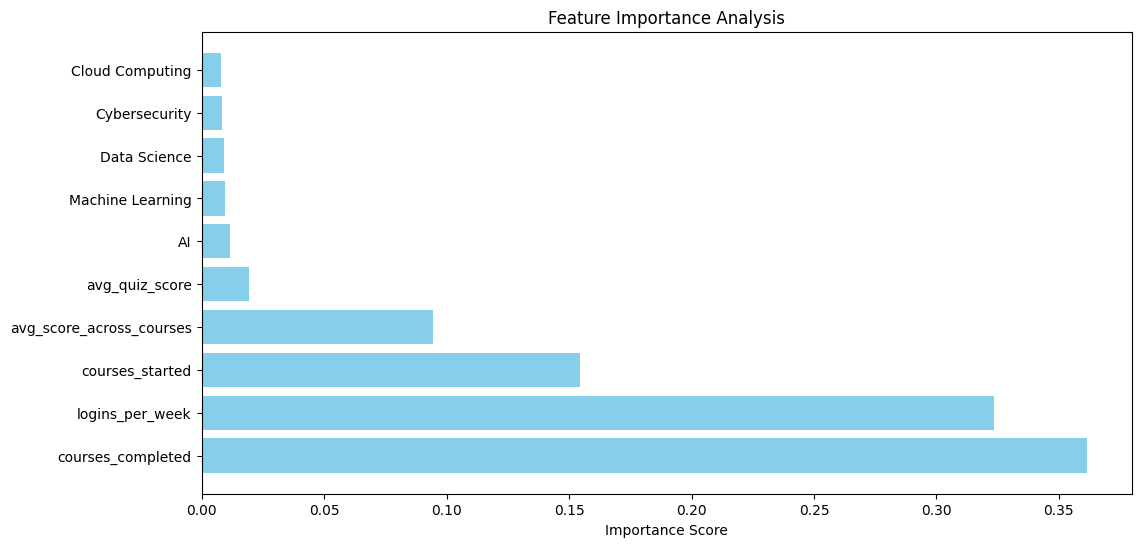

In [ ]:
import matplotlib.pyplot as plt

classifier = pipeline.named_steps['classifier']
numeric_features = ['courses_completed', 'courses_started', 'avg_score_across_courses', 'logins_per_week', 'avg_quiz_score']
categorical_features = ['AI', 'Data Science', 'Machine Learning', 'Cybersecurity', 'Cloud Computing']
all_feature_names = numeric_features + categorical_features
feature_importances = classifier.feature_importances_

importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance Analysis')
plt.show()